In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import datetime
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [2]:
test= pd.read_csv('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/IAT_sebastian/dataset_26_april_3.csv')

In [3]:
longTime=test.loc[0:,['longTime']]
longTime=longTime.as_matrix()
a=[]
date_time_array=[]
for k in longTime:
    a=np.append(a,k)
str_time=[]
correct_longtime=[]
datetime_time=[]
count=0
for b in a:
    b=int(b) # make plain integer
    str_b=str(b)
    c=str_b[-3:]
    new_str_b=str_b.replace(c, '',1)
    new_str_b_time=int(new_str_b)
    correct_longtime.append(new_str_b_time)
    now_time=datetime.datetime.fromtimestamp(new_str_b_time)
    convert_time=now_time.strftime('%Y-%m-%d %H:%M')
    str_time.append(convert_time)
# print(str_time)
test_new = test.assign(stringTime=str_time,correct_longtime=correct_longtime) # here new column in the panda dataframe for string_time has added

/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [4]:
test_new['dateTime'] =  pd.to_datetime(test_new['stringTime'], format='%Y-%m-%d %H:%M')

In [5]:
test_new.shape #ROWS, COLUMNS

(25000, 4223)

In [52]:
multivariate_data=test_new.loc[500:24999,['dateTime','AEDATZ_HO_V0','AEWIHO_T9AV2','AEWIHOAVABV2','RWWIHOA_HWT0',
                                          'AEWIHOAKZ_V0','RWWIHOA_MWT0','AEDAHO_T9_V2']]
multivariate_data = multivariate_data.set_index('dateTime')
multivariate_data=multivariate_data.loc[::-1]
univariate_data=test_new.loc[500:24999,['dateTime','AEDAHO_T9_V2']]
univariate_data = univariate_data.set_index('dateTime')
univariate_data=univariate_data.loc[::-1]

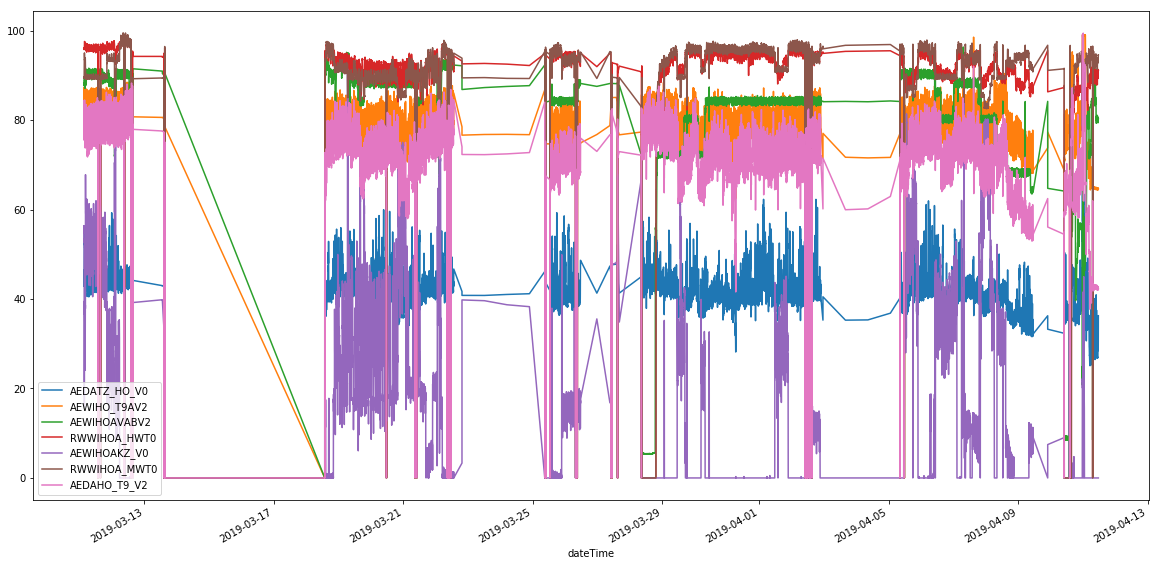

In [53]:
multivariate_data.plot()
plt.rcParams['figure.figsize'] =(20,10)
plt.show()

In [54]:
# remove this line if you want do not want to count mean. Just comment it and uncomment the below lines.
multi_mean=multivariate_data.mean()
multivariate_data_mean= multivariate_data.replace(0,multi_mean)

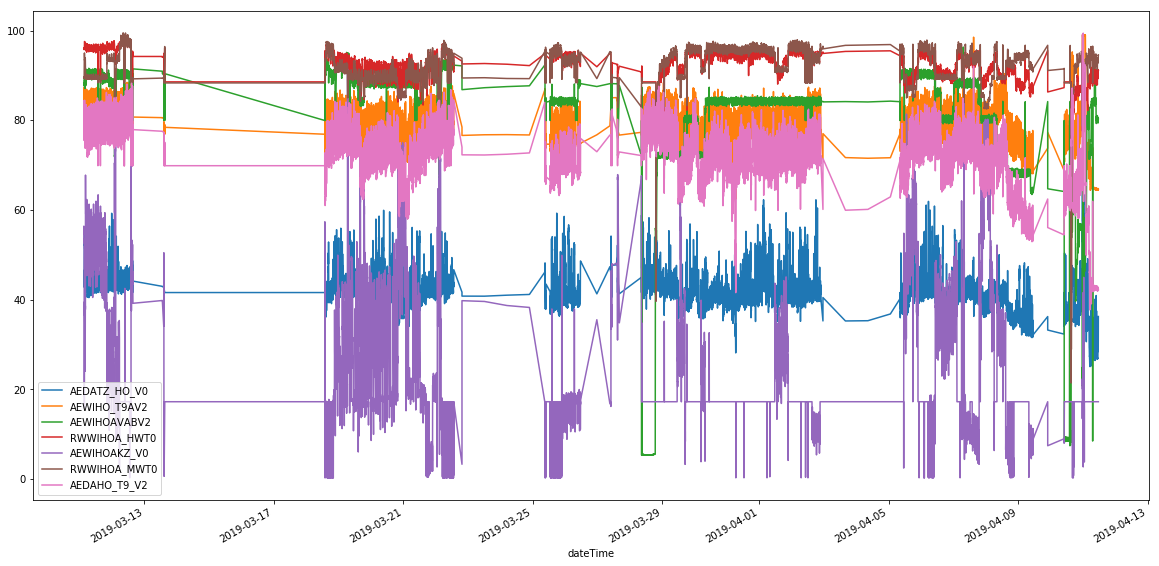

In [55]:
multivariate_data_mean.plot()
plt.show()

# train and test dataset making

In [78]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(multivariate_data_mean)
df_normalized = pd.DataFrame(np_scaled)

In [67]:
# dataset=np.array(multivariate_data_mean)
dataset=np.array(df_normalized)

NumberOfElements=int(len(dataset)*0.9)
print('Number of Elements for training: ',NumberOfElements)
print('dataset length: ',len(dataset))

multiple_ip_train_data=dataset[0:NumberOfElements]
print(multiple_ip_train_data.shape)
multiple_ip_test_set=dataset[NumberOfElements:len(dataset)]
print(multiple_ip_test_set.shape)

Number of Elements for training:  22050
dataset length:  24500
(22050, 7)
(2450, 7)


In [68]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix,:-1], sequence[end_ix,-1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_1 = 4
# split into samples
X_Conv_Lstm, y_Conv_Lstm = split_sequence(multiple_ip_train_data, n_steps_1)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = X_Conv_Lstm.shape[2]
n_seq = 2
n_steps_2 = 2
# X_Conv_Lstm_train = X_Conv_Lstm.reshape((X_Conv_Lstm.shape[0], n_seq, 1, n_steps_2, n_features))

In [69]:
X_Conv_Lstm_train = X_Conv_Lstm.reshape((X_Conv_Lstm.shape[0], n_seq, 1, n_steps_2, n_features))

In [70]:
print(X_Conv_Lstm.size)
print(X_Conv_Lstm.shape)
print(X_Conv_Lstm.shape[0])
print(X_Conv_Lstm.shape[2])

529104
(22046, 4, 6)
22046
6


In [71]:
# define model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

lr = 0.01

def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size=32
epochs=10

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps_2, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_Conv_Lstm_train, y_Conv_Lstm, batch_size=batch_size, epochs=epochs,validation_split=0.2, verbose=1,
         callbacks=[LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('/media/atif/BE0E05910E0543BD/University of Bremen MSc/masters_thesis/forecasting_sensor_data_Salzgitter_AG/trained_model_file/conv_LSTM_100.h5', save_best_only=True)])

Train on 17636 samples, validate on 4410 samples
Epoch 1/10
17636/17636 [==============================] - 5s 266us/step - loss: 0.0057 - val_loss: 0.0031
Epoch 2/10
17636/17636 [==============================] - 2s 133us/step - loss: 0.0033 - val_loss: 0.0044
Epoch 3/10
17636/17636 [==============================] - 2s 133us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
17636/17636 [==============================] - 3s 146us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/10
17636/17636 [==============================] - 3s 142us/step - loss: 0.0023 - val_loss: 0.0041
Epoch 6/10
17636/17636 [==============================] - 2s 134us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 7/10
17636/17636 [==============================] - 2s 136us/step - loss: 0.0021 - val_loss: 0.0034
Epoch 8/10
17636/17636 [==============================] - 2s 137us/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/10
17636/17636 [==============================] - 2s 136us/step - loss: 0.0020 - val_loss: 0.00

In [72]:
X_Conv_Lstm_test, y_Conv_Lstm_test = split_sequence(multiple_ip_test_set, n_steps_1)

x_input = X_Conv_Lstm_test.reshape((X_Conv_Lstm_test.shape[0], n_seq, 1, n_steps_2, X_Conv_Lstm_test.shape[2]))
yhat = model.predict(x_input, verbose=1)
print(yhat)

2446/2446 [==============================] - 0s 155us/step
[[0.3492557 ]
 [0.33720744]
 [0.3402214 ]
 ...
 [0.16729575]
 [0.22320628]
 [0.27940613]]


In [76]:
from sklearn.metrics import mean_squared_error
from math import sqrt

#Print MSE to see how good the model is
Error = mean_squared_error(y_Conv_Lstm_test,yhat)
print('mean squared error: ',Error)
print('RMSE Error: ',sqrt(Error))

mean squared error:  0.008328398856411208
RMSE Error:  0.09126006167218609


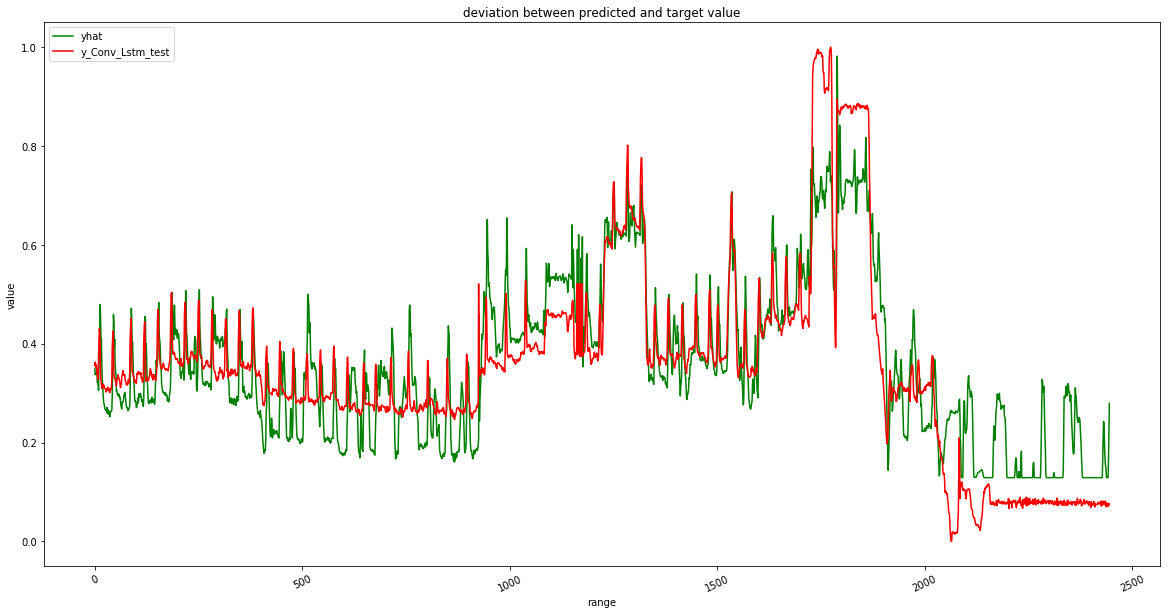

In [74]:
# my_data_1.index[0:-1]
plt.plot(yhat,color='green')
plt.plot(y_Conv_Lstm_test,color='red')
plt.xticks( rotation=25)
plt.title('deviation between predicted and target value')
plt.ylabel('value')
plt.xlabel('range')
plt.legend(['yhat', 'y_Conv_Lstm_test'], loc='upper left')
plt.show()

In [81]:
for i,j in multivariate_data_mean.iterrows():
    for o in j:
        print(o)
    

46.11938837586608
79.17830627909903
88.2697689645123
96.06365927057912
54.778230911941755
89.56613036318787
83.32736135675994
46.534540534907656
81.65911664779162
88.1703602269234
96.10336224014164
54.704686601075096
89.37737955765017
84.3148141327593
46.55563074179414
86.05542972190763
88.26138509507709
96.03853581699444
56.41528729146339
89.39284230647803
84.3809434064285
45.94044924535742
87.1136907008934
88.27855206582537
95.95750773362215
55.23093172226419
89.34483528795917
83.27985328724495
44.218946986350886
87.26626399899334
88.05258682295265
96.01827879615136
53.03721159002981
89.45548779113192
79.96312394257812
43.149993894821186
86.6153894551403
88.09730079327376
95.99883284743191
53.41457875821948
89.5897167655425
76.76810831291303
42.85596920639996
83.38492512897949
88.27895129770323
96.01827879615136
52.914460669345495
89.57182089310335
76.26673655413882
42.8788308641327
79.8361016735875
88.23703195052721
95.97452046597084
53.469153361835424
89.55392502066418
76.360077666

74.69844130431886
41.79122331063015
78.63973826601233
90.21921822413677
95.78329537614708
54.20403380969386
89.39365665805407
74.97961560976069
42.02500963226397
78.43588775638607
90.23638519488505
95.80274132486656
52.423289236802
89.36029803678703
75.39778457627503
42.058771135509936
78.60041525103813
90.1377749210519
95.76303835530399
51.98991460206845
89.39771848481745
75.84509998832378
41.91294277120167
78.50226500566252
90.08308015378412
95.82299834570959
51.957706639278705
89.48151724821464
75.41858527434
41.80087591013936
78.52680256700641
90.33938701937471
95.7363026485956
51.700399405298974
89.42944840293241
75.24397597678549
41.567089588505524
78.52019630049075
90.28109916520617
95.63501754438023
51.79738325679399
89.4131812336453
74.7767561529317
41.53818601806501
78.53970051591794
90.25195523812187
95.71847884412331
49.0518326631379
89.43270580923655
74.21427530309168
41.58456458958331
78.61834654586637
90.29028149839708
95.71928991624694
52.171353491408176
89.497784417501

42.92838460221733
89.53602914822498
75.81261818244509
42.290781487290246
78.72341764187745
90.34298010627552
95.20962010667576
43.510451966205956
89.85493717029313
76.08660750459016
42.293149447094954
78.78885113879451
90.1864812101517
95.43892602181488
50.139029641460645
89.77521016477608
76.04590729245928
42.44501972411099
78.76871775512771
90.35735245387876
95.45674982628715
50.88410787962078
89.44652992379555
76.03473554951458
42.57278109739031
78.7441801937838
90.2407767455416
95.36033115481341
50.83722879836411
89.41236688206926
76.33581426676143
42.58000699000044
78.86844092110229
90.11342177650202
95.58801492570532
51.133719591241245
89.41399558522134
76.10881875152319
45.01128712443547
78.72593431483578
90.27590915079388
95.55236731676077
50.97697487128872
89.45304473640383
80.52881770928431
46.08325891281543
78.90713476783692
90.34577472942058
95.67553158606638
50.83365013583191
89.55473937224018
83.87263644905293
46.39955326901822
83.08953064049327
90.31343694731336
95.67634

42.0165997597515
78.25217063042658
89.44231298980762
96.55225109606012
54.92012278447064
89.35948368521099
74.92967336390045
41.98709968035254
77.97659494148733
89.36086968672275
96.44854266659745
52.816047449710176
89.3619267399391
74.81617315741177
42.166630800812385
78.12790990310809
89.58324184269466
96.41045195015863
52.816047449710176
89.45060168167572
75.02134434710786
42.163612103962116
78.21442053605134
89.41237059896758
96.46393325469893
53.14886306520415
89.49778441750178
74.94019860528063
41.88646590766024
78.14049326789984
88.39752316542973
96.2338162674362
51.19813551682073
89.39202795490198
74.94148181293144
42.08589873609694
78.08198062161823
89.21235542815624
96.20950388597514
50.84849948846793
89.30741483992875
75.25488813955656
42.388988553083465
77.97565118912797
88.81272431841137
96.10659663751257
48.78003254486031
89.37250337931076
75.48843193200526
42.314235134974155
78.16660374984271
89.5077870177778
96.12685365835566
48.65800155042758
89.62388973838556
75.32280

76.17583941371319
43.971888340391864
78.57776519441299
88.11047544524338
96.27270816487514
25.967848233395337
93.32801753755774
76.04410982220031
42.96323688175122
78.13640367434252
88.26138509507709
96.12847580260285
24.519564555053073
93.3524182914884
75.83714116224526
42.534812398384474
78.27733736001007
88.10169234393028
96.15035496769312
22.5767090158042
93.48910025174385
75.52168268292665
42.011800574040464
78.1574808103687
88.23343886362639
96.18924686513206
22.73971639518807
93.5224588730109
75.61245737987413
42.07505763767811
78.30218950547376
88.17475177757994
96.10578556538898
24.05845353830123
93.48502849386372
75.44426412057372
42.0961478445646
78.14143702025922
88.26457895010002
96.10659663751257
22.333001747883085
93.40285843361859
75.46698963011491
41.93402845908089
78.0684535044671
87.48168523760286
96.12037497249031
21.96958751930259
93.52083016985884
74.91310921017882
41.92141139080855
78.03479300364918
87.98272124432594
95.93562856853191
20.240915282084227
93.431340

74.59200363764879
42.09371661865824
77.78344029193406
90.24516829619812
96.94604639431459
35.38313112142633
93.84218124665509
74.59829233468562
42.20702620671729
77.87938844847113
90.29028149839708
96.96873663152846
34.43943711272947
93.78686492618549
74.6945867836273
42.108823659931325
77.80546118031963
90.28628917961842
97.03112983830486
35.331418748878605
93.68272723562099
74.85995404745243
43.83814380149918
77.87120926135648
90.19366738395328
97.02707447768688
34.59349783578286
93.66320266002977
77.23955978337105
45.54276756838637
78.05240971435762
90.16372499311326
96.90796556899923
34.408662012867666
93.57614649032844
81.97219122497548
46.17062488018982
80.35925506480433
90.06830857430306
97.071643879991
34.53928319529271
93.5615080241934
83.43611075629711
46.328473803811995
85.28815905373095
90.28389378835121
97.0092506732146
34.28895505220828
93.62577228088257
83.85620943202682
46.042266997952076
86.03655467472002
90.1812911957394
97.0092506732146
33.76468099124199
93.503738717

17.272872145074913
97.62929345764842
76.94002385394862
42.740879129480135
78.97665785831131
91.14383925327671
97.54403404524695
17.272872145074913
97.52434141550788
77.06302077660119
42.94511114362789
78.87945136529508
90.83762840295273
97.43627025516626
17.272872145074913
97.41857502179134
77.3263526184097
43.31329274119998
78.96250157292059
90.41444261241371
97.32931753720919
17.272872145074913
97.3429197741545
78.10825707880029
43.325968556566714
78.9278973197433
90.2347882673736
97.2450451653425
17.272872145074913
97.15905507807295
78.28980157495617
43.12410902123093
79.23587517302127
90.07270012495958
97.22803243299386
17.272872145074913
97.32339519856323
77.90642614718763
43.05119483907679
79.48722788473637
90.14256570358631
97.96051958071527
17.272872145074913
98.12718999745859
77.66966943787276
42.54322678990422
79.52875298854914
90.21921822413677
98.04884731319996
17.272872145074913
98.36962842031386
77.00562906953144
42.343201971516336
79.60771360261734
90.14017031231913
98.2

80.49484082043539
89.21954160195784
94.72749707593664
42.106005156489246
89.39527543008936
78.8587033607894
47.68659365095749
80.52283880709702
90.03157924153929
94.70481672984623
40.507237670231966
89.41399558522134
78.72710111049378
46.959941802416886
80.43569900591419
89.96929906859205
94.6602473275421
41.34929975988712
89.46199267262341
78.51409843593639
46.355009414447835
80.51749087706052
90.22161361540395
94.553294609585
40.971212665445854
89.36111238836305
78.15280691388364
45.29086002763644
80.70561218069713
90.21682283286957
94.462543551853
40.882819001943176
89.40748077261307
78.2768323617525
44.165934512173614
80.74430602743173
91.48079095819644
94.25429583855707
39.219457355937344
89.25860340095066
77.94301715619244
42.995163668049265
80.61029319239965
90.96418490823656
94.24781715269177
39.84250110487711
89.42781969978034
77.5750451179728
42.90838969062605
80.51591795646156
90.43600113381856
94.06225967660973
39.6440670632971
89.36111238836305
77.53755782270811
42.9186342

71.34755512699249
40.199909131802
76.0620359884233
90.5733368998048
95.57262433760384
17.272872145074913
96.20801161066723
71.47594446042196
40.318609895523274
76.06518182962124
90.67314486927151
95.68606563254973
17.272872145074913
96.50413765084
71.5204991932444
42.581190969902785
76.2202718006795
90.65358250725605
96.00045499167909
17.272872145074913
96.74739042527126
75.27363178718892
43.765229619345035
76.09223606392351
90.6859202893633
96.06446045157922
0.31969623734039393
96.83526094654863
78.9673205213702
44.2249843800514
79.65206996350824
90.64360171030935
96.12847580260285
17.272872145074913
96.8881441434069
79.85052492008847
44.24423535098271
83.58846105448599
90.65837328979043
96.17061198853621
17.272872145074913
96.9223071851332
80.03566435676228
44.09781499672327
84.32238580596452
90.57493382731627
96.17142306065979
17.272872145074913
96.92312153670922
79.98058438255966
42.279289651825856
84.44916320624134
90.57213920417118
96.21598257184047
17.272872145074913
96.94021298

73.1798287201855
47.95355400489336
76.6801937838178
92.29282859777788
94.77044433399357
38.68820420407575
91.06958227041416
73.39436928482822
45.86871904310564
76.71416886875551
92.00897473261446
94.7485651689033
38.89379906550776
91.12002241254434
73.2501847427198
44.35754493904176
76.66226248898954
92.27725855454108
94.7210183900713
38.29007799736926
91.08178761293787
73.23670616464709
42.96803606746227
76.6603749842708
92.3048055541139
94.51278056789886
38.93244792189793
90.97276381291721
73.21474960014858
41.906959605588284
76.8576192273814
92.20659451215862
94.50953627940444
34.91593742680604
90.81005239557902
73.21384841614953
40.90245207660585
76.6109852774632
92.21817223661677
94.40419581457114
34.56594493011508
91.08503508812522
73.21359373371502
40.822962738887156
76.64338744180193
92.18303983136448
94.37989332423349
34.79157890381233
91.06632486411004
73.13489196371128
40.72469692599954
76.7144834528753
92.18343906324232
94.27536393152376
34.480769966018784
91.03215189126698

42.78725770099844
75.94784195293822
94.3193296098307
94.90252050553532
41.85084721690141
91.40150998658207
76.43891167534807
43.88872956877735
75.8160312067447
93.97399403547577
94.9584350264464
43.48307729470726
91.26565230901942
79.41874513654504
44.35150302633397
79.82855165471247
94.36005126137312
94.77125540611719
42.0915122721914
90.82144338652672
80.38643063743487
44.572026061657155
83.30439159431232
94.23668861111223
94.77531076673516
38.13297680907856
90.9117470314154
81.31380284758471
44.33278981726672
83.88291179061281
94.15604377178309
94.89198645905199
38.3120881698573
91.0492433432469
80.87649841430796
42.9661968315071
84.06128098653579
94.12290752592014
94.6448567394406
38.71039261073287
91.03134747080773
78.06370234597786
41.67856445961666
83.66459041147603
94.2067462202722
94.72345160644208
38.826699143029145
91.01262731567572
74.93544779832912
41.473089718472174
80.95507738769348
94.30575572598322
94.5759749556754
38.74045477391834
90.95649664363009
74.54180181161493


45.04623260758378
76.61161444570278
88.64744232097445
94.03714611414853
18.97210118025269
92.93506310877123
73.54446050032169
44.40031282375863
76.74342519189632
88.61510453886723
93.96665207725955
18.428322709528423
92.89519960601272
73.45021820407351
43.50188899022511
76.66226248898954
87.50883300529782
93.71707925015394
18.235611382691054
92.73655994655468
73.62252066650001
42.66014706476471
76.88184220460552
88.29412210906217
93.73490305462622
15.751733012763452
92.63242225599022
73.3531548100892
41.5562484900867
77.05423430225242
88.54523896024051
93.646585213265
17.945739717583415
92.5950018079598
73.2975605732784
41.22905428837068
76.9856549641374
88.50331961306448
93.5047860673635
18.150259931819487
92.51120304456259
72.99237755064458
41.21940168886147
77.0057883478042
88.67578778430301
93.59472605297192
18.712289930936702
92.56977677133631
73.30757644978954
41.23207750422821
76.95514030451744
88.56520055413384
93.3378733590008
19.598903573287547
92.36883055439169
73.0346156528

57.584797002814206
85.1965084974111
66.83062011646432
39.73896587218603
74.95784572794766
88.20828725532076
89.84069851113865
55.81801061171294
85.2526491005735
66.4261893081963
39.264167336308226
74.40417767711087
88.19311644396183
89.79694018095812
52.51078823467163
85.39583594232045
66.32539873473766
38.82786622328578
74.13835409588525
87.60664481537523
89.72725721619275
54.48620995244222
85.54145590767874
66.03395387035019
38.93934109439691
73.93481817037876
88.25659431254267
89.51658617764953
54.55599387181999
85.26241138836912
66.97018119283848
38.59591913760712
73.94928903988927
87.8609555215765
89.44690321288418
50.87140432658902
85.20058025529126
67.60944389894514
39.285845014138616
74.32741915188122
88.21866728414531
89.21597515349787
49.47966106990407
85.36979655412095
68.29851661195565
40.03180658070491
74.77381401786838
88.14760400988499
89.17221682331734
49.03053892211385
85.32505687302302
68.23316607880736
40.80786021662133
75.21077136026173
89.03908879316197
89.09118873

74.76940984019127
88.02863291028063
90.24827214437084
18.205909182631377
89.25371729149444
68.81003158845826
38.71278066537321
74.57216559708066
88.30849445666539
90.15994441188616
17.76607268557165
89.28381850645735
68.6487686300201
38.92311333932314
74.77633069082673
88.19551183522904
90.01328872436655
17.894029092429513
89.1642279981818
68.8850110767268
39.04779726865779
74.99874166352083
88.24341966057307
89.9687193220624
18.093895996937448
89.19514356472072
69.18993941692611
39.01527849240857
75.16452749465208
88.08731999632708
89.87877933645399
17.315072089430775
89.08938710212097
69.05076526194284
38.973694587594046
75.19724424311059
87.48048754196927
89.68755424663023
16.960856141890055
89.01535062651939
69.07335853252765
38.90741430809887
75.24034226752235
88.13403012603752
89.55872236358287
16.265861705242482
88.85832973909666
68.81773083436316
38.65799222134242
75.28564238077261
87.9807250849366
89.42826833628831
16.29196776883182
88.78673631822315
68.62180657613555
38.55795

69.03831031134732
49.834093686431686
75.18591921479803
88.24222196493946
91.88827976053592
33.861304879611204
89.42050046671282
68.46773839647237
49.317119255788185
75.11136277840693
88.01066747577661
91.89800273489566
33.823190725728296
89.56937783837523
68.47415933246558
48.41028554974221
75.2475777022776
88.51010655498821
91.58765884526079
33.59129409259971
89.46686885096283
68.5129298353811
46.76530815969124
75.22587139801183
89.24828629716427
91.64842990778999
34.095707275469856
89.49941312065383
68.21724842665029
45.58494346315207
74.90814143702026
88.38714313660519
91.5828023036427
33.74285254771066
89.44734427537159
68.48263242115227
44.47861366256772
74.54888637221593
88.21866728414531
91.48232827155093
27.462119822148857
89.43433451238863
68.12955440761257
43.48382199919616
75.03806467849503
88.19670953086262
90.97671382259777
31.699076278702602
89.53846227183632
68.33857522026112
42.839678185224535
75.16358374229269
88.18952335706102
90.78548873277398
31.15780357070839
89.06

70.13554101210015
39.76248278597159
76.37724927645652
88.15399171993086
92.73016273370872
41.839754760966656
89.36355544309116
69.9681166978424
39.76728197168264
76.43890776393606
88.28374208023762
92.82253593568792
39.80939847645432
89.47825984191051
69.98005738582978
39.73837388223485
75.66345790864476
88.14800324176286
92.49193502521
39.94109605346913
89.33101117340017
70.18959246108648
40.28668310922522
76.01201711337612
88.26697434136723
92.5259703810308
40.23490284944713
89.45954961789529
70.3910413690474
41.50987443757565
75.99125456146973
88.14560785049567
92.34365719344318
38.0698120174703
89.29196202221769
70.46858727261755
43.29700623903181
76.03403800176167
88.19191874832823
92.45871074151279
37.2655076133599
89.4180574119847
70.23504348016886
44.27616213728076
75.97741286019883
88.2246557623133
92.26667457956543
36.4527947502139
89.51487586948168
69.89480733861558
44.48524756522667
76.05228388070971
88.19670953086262
92.03170105068459
35.91778470165102
89.38958490017392
70

42.625201581616395
75.2824965395747
88.30050981910804
90.7862998048976
31.67581497224334
89.55473937224018
75.59756335519424
43.494663097614996
77.43236441424438
88.22705115358052
90.70040528878373
31.13418579591097
89.55636807539227
77.36166041976367
43.7151816139309
82.01113627784069
88.31967294924566
90.63557886563652
31.82987569529673
89.58890241396648
77.97537162085386
43.0626279274468
83.1968038253429
88.18113948762581
90.55455078226423
31.542509792919148
89.55311066908811
77.21452254096273
41.12782852572721
83.58783188624639
88.10768082209829
90.61937720541144
31.031299248110415
89.50104182380589
73.01740989531376
40.44210532594831
82.81584245627279
88.34602225318487
90.67285850995172
31.45232679815036
89.50104182380589
71.2239117027754
40.335488387642606
78.82471372845099
88.28653670338271
90.39979426463205
31.84920187088563
89.47988854506258
70.924375773353
40.160164462942646
76.81986913300615
88.13602628542685
90.33577891360845
30.72246137053968
89.37737955765017
70.728064593

66.36764173469301
38.90439561124861
76.11740279350698
88.10528543083109
87.32963899872158
40.6040432875579
85.21847612773044
66.11637792208911
38.28921863381915
76.01044419277716
88.07693996750255
88.81083473663648
56.66508073204058
86.42742076681925
66.2782824843527
37.742687636185934
75.96388574304771
88.27615667455817
90.75307552120042
63.51231329009722
86.55108303297497
66.34478888393457
37.80594695932722
76.00824210393858
88.1739533138242
91.57551254565372
67.24986983663474
86.15488112900113
66.7728463857428
37.57938653030352
76.07996728325155
88.05458298234197
91.92798273009844
71.65734921336873
86.11583197781864
66.27584341026832
37.90053881931174
76.02460047816788
88.13642551730473
92.30314315175706
71.86222764333681
85.6895288588819
66.24849443499289
40.075758445324134
76.02302755756891
88.21507419724449
92.51624740667108
72.75778794201811
85.58620551989345
71.46464537626
41.074816051549945
76.49333081666038
88.20229877715276
92.67587035704484
72.69104448787766
85.582948113589

89.06863195212412
91.3858997089537
37.923265087819466
89.31473407299629
69.11418608587579
39.58893483112515
76.01201711337612
88.744854899174
91.25625675378276
35.624512608180275
89.48396030294275
69.64534099627066
39.53289914109037
75.24506102931925
88.33963454313901
91.05044225685765
32.1419357670615
89.49941312065383
69.97479721400926
39.50334483360428
75.75279979866615
88.20189954527491
90.52862614767945
36.14932137165382
89.92734494274264
69.60977851248218
39.74435704784825
75.80030200075501
88.15319325617511
91.08772190117284
37.346922185967294
89.3806369639543
70.43096773839648
39.90286122752325
75.75783314458286
88.16636790814474
91.00750488992416
38.05549736734153
89.47988854506258
70.19922141620674
39.882367529595214
75.77482068705172
88.29651750032939
91.07962107106032
37.91378372898173
89.37982261237828
70.36600412663907
41.3549809447021
75.91418145212029
88.30569983352032
90.76523171193092
37.57738945095558
89.46768320253885
72.26799213854099
43.4229328953632
76.0129608657

88.80191294327689
19.96160137040408
89.03080344423046
70.44701762950993
39.561215240586975
76.2001384170127
86.47003165908792
88.59286404898087
19.719325218017087
88.79975601232292
70.06698245982483
39.757624853166156
76.6109852774632
87.67491346649048
88.57017381176699
17.735206721231485
88.64436382805224
70.32311952285832
39.67328210164929
76.55373096766075
85.38092709626679
88.4972564496307
18.84273113179885
88.5508027768594
70.69275679238051
39.58170893851502
76.45967031584246
85.23999824337973
88.1812449462541
19.21849069767913
88.34498038157534
69.97620776287732
39.652191894762815
76.62797281993205
85.73943732259134
88.0532142442069
18.858298663292658
88.33846556896708
70.48040061938768
39.6774847784019
76.17339876683026
85.80810520558447
87.96732961921649
18.379294333879848
88.1489103429701
70.55114356331288
40.233019898002404
76.65628539071348
85.66038941077367
87.8838683194734
19.696780343021796
88.145652936666
70.78982508410397
43.00961545326953
76.4134264502328
85.8468306977

95.71580560077247
82.33926207919605
45.97835919726886
83.72373222599724
92.23014919295277
95.24284439037298
5.9250127087952125
95.8158715334568
83.63909265660422
45.821097744590595
86.0673839184598
92.29921630782377
95.18207332784377
6.463655152250071
95.73288712163559
83.6468016979874
45.11434760402688
86.99823832892916
92.31598404669417
95.24364557137312
4.476638602823047
95.79879001259363
82.47933741817836
43.17954820230728
86.72895432238579
92.22815303356344
95.22177629740631
5.6466104998378075
95.73125841848356
78.497152258563
42.35581903978869
85.90537309676607
92.16786902000551
95.17801796722576
3.2353614616907316
95.76380268817458
76.33337519267705
42.249202101482986
81.84377752611049
92.13113968724177
95.11562476044935
6.891591460584282
95.69139491572504
75.73622814530846
41.90210167278285
79.44696111740281
92.27526239515173
95.11481368832577
4.4219565344875065
95.5864528047013
75.34424738989686
41.58817527638474
79.20127091984395
92.23334304797571
95.0929345232355
5.207133092

78.092991065811
92.07684415185184
93.42943548885643
22.39455369500052
92.04259336813922
75.40934324061064
42.557086585173295
78.05492638731597
92.21138529469302
93.22037670343693
22.807174533398673
91.9205598051356
75.57714957852015
42.475762530506685
78.17100792751981
92.18423752699806
93.17742944538
22.661702250943783
91.88476806025723
75.58562266720683
42.32875018629608
78.03510758776899
92.21457914971596
93.12800350145771
22.480979793068034
91.846523329534
75.57355463800222
42.06961223392877
78.3050207625519
91.5790020001517
92.91976567928528
22.913281527999434
91.72287099449508
74.86059565127783
41.780382212211315
78.38555429721907
91.64886757877844
92.89950865844222
20.79399687747715
91.63581482479374
73.85208259703987
41.492991426449045
78.08764313577451
91.88601131423141
92.91328699341992
23.000958760038166
91.59839437676331
73.19702957999341
41.46527183591087
77.6333836667925
92.20020680211277
92.70179499162964
21.60080704431761
91.51133820706198
73.11948367642322
41.188717629

82.76299232414748
92.32556561176298
96.81721451126724
17.272872145074913
97.29329398360035
76.55870057887358
41.09833296533551
82.31470995344155
92.16627209249405
96.85529533658257
17.272872145074913
97.20380469028768
72.78168660895432
41.07120536474851
80.55492638731597
92.29682091655657
96.74834261862549
17.272872145074913
97.09803829657116
73.34185572592722
41.17782230305421
76.77740027683403
92.2529054099912
96.661637030388
17.272872145074913
97.02481617254558
73.40682423542374
41.19292482532003
76.76985025795898
92.1522989767687
96.55711752880173
17.272872145074913
96.8857010886788
72.54724163250656
43.25903754002598
77.22914307285768
92.20419912089142
96.53199407521706
17.272872145074913
96.84828064064838
72.13382347294372
45.390309820426396
76.43104316094124
92.14351587545565
96.40478433641691
0.6294903215700878
96.75634829260763
72.28968912286584
47.11358804928646
76.65848747955205
92.11716657151639
96.33833576902248
0.5451537788684311
96.57980282959365
72.30625327658747
47.768

84.11376511591699
95.28578175730644
0.9395921109293122
96.15349971065692
66.80853621074854
38.01444039732197
74.82037246759783
84.34931192385852
95.24041117400219
17.272872145074913
96.08597804766359
66.30948108258058
37.863815106806285
74.77601610670693
84.17484759323064
95.11724690469656
0.4429274728994946
96.06563912049631
66.21254502981351
37.973453001465884
74.32962124071976
84.2211584910632
95.16019416275351
0.542473331362972
95.978582950795
66.01354009367611
37.87346996581913
73.90210142192022
84.28343866401045
95.19827498806885
0.4429274728994946
95.94522432952795
66.13872140797854
37.945141420976526
73.9533786334466
84.15169214431435
95.09536773960629
17.272872145074913
95.978582950795
66.03331226652477
38.0487938905191
74.27456901975589
84.31817183738487
95.11562476044935
17.272872145074913
95.95987272677978
66.24631004334303
41.6154225199946
74.4265131496162
84.11256742028337
95.11238047195495
17.272872145074913
95.92407105078465
69.89687745791552
38.52661564225443
74.492261

84.23712776617788
95.22177629740631
17.272872145074913
95.5840097499732
67.2351831636887
38.08617059957375
74.42147980369951
84.15807985436022
95.17882903934937
17.272872145074913
95.47987205940872
67.21502406944916
38.247634729004616
74.60897193909652
84.30140409851447
95.13669285341604
17.272872145074913
95.44326596295436
67.16353903576447
38.36515151282355
74.30634201585505
84.27705095396458
95.11238047195495
0.8848958996250861
95.3724868936569
67.37461689884562
38.53141482796546
74.367371335095
84.26786862077364
95.02811799121174
17.272872145074913
95.31960369679862
68.05021103378343
38.45192549024677
74.37366301749087
84.19121610022319
94.98517073315479
0.44244794981254304
95.28218324876819
67.74849071271116
38.41336480128976
74.85843714609287
84.20079766529199
94.96572478443535
17.272872145074913
95.21628035781019
67.64487904151638
38.25243391471568
74.97451868629672
84.22674773735335
94.98354858890758
17.272872145074913
95.24556722119705
67.53972458249713
38.23436692368672
74.57

95.17801796722576
17.261535437740672
94.305914744739
75.95359470542645
46.21398023585061
84.60425317729961
84.28343866401045
95.11562476044935
16.718814140274205
94.28557581757171
72.8017134642375
44.641917027953774
83.89895558072229
84.34412190944623
95.11805797682017
18.531745707230037
94.21967292661371
69.50745004893821
43.9712963504407
80.62444947779035
84.08142733380977
95.20394260181057
18.06473024677884
94.27174177189596
68.89104509132912
43.40427391438307
77.83566125581982
84.24591086749095
95.24364557137312
17.33949716017052
94.28800894118305
68.58855582521419
40.628329096161494
77.27035359255066
84.31218335921687
95.2193430810355
18.256010458082088
94.26767001401579
68.01194989573693
39.026115071820136
77.04385302629923
84.21317385350586
95.11238047195495
18.55930210768545
94.16028484826393
67.91064995740926
38.74233949186657
76.85352963382408
84.07024884122949
95.00948311461588
17.217338605989326
94.03906563683631
68.16781554565908
38.500730768664155
76.88813388700139
84.205

94.99327156326734
16.685531530288518
94.81194486919279
68.00565630096098
38.60373702016842
74.5554926387316
84.16606449191757
95.18855201370909
16.460075790760353
95.02753948338926
68.24510676679473
38.91647943666417
74.58160312067447
84.14410673863487
95.34736389195926
16.864607943190972
95.1959414306429
68.42511337286528
41.211583806300176
74.91726437649426
84.11296665216125
95.20313152968698
16.414215440097554
95.19675578221893
73.23708818829887
42.4619027352376
74.9852145463697
84.23153851988775
95.24688985986752
15.646574853003989
95.21546600623415
75.33461843477662
42.60411589373717
79.34189002139172
84.1025866233367
95.30603877814951
17.720607245910944
95.24882462750118
75.74649870425414
41.99189886606359
81.6207373851768
84.30060563475872
95.20475367393419
16.785788250398177
95.23092875506201
75.72788239783905
40.45116593550636
82.00484459544481
84.24750779500242
95.28497068518286
17.08185093179076
95.19431272749084
73.10138163261628
38.940583821393645
81.78778155278722
84.2027

17.272872145074913
88.35441490522537
71.58572238517544
43.12168231433185
76.86107965269913
5.453467684425165
88.58830464518908
17.272872145074913
88.35441490522537
71.26448457368903
41.87799728805337
76.36655341638354
5.4407717988090925
88.58830464518908
17.272872145074913
88.35441490522537
71.7953848016494
40.85548151513637
76.39549515540456
5.474267509312083
88.58830464518908
17.272872145074913
88.35441490522537
72.39060703754176
40.738561240275885
76.47571410595194
5.480056371541155
88.58830464518908
17.272872145074913
88.35441490522537
72.18004343706875
41.03382865569386
76.79690449226123
5.458098618258472
88.58830464518908
17.272872145074913
88.35441490522537
71.98514770405744
42.56372048783226
76.95073612684033
5.466202947404195
88.58830464518908
17.272872145074913
88.35441490522537
72.19070091740531
45.105286994468834
76.48955580722286
5.4523097560294005
88.58830464518908
17.272872145074913
88.35441490522537
72.34798201393465
47.93726298371793
76.36686800050333
5.480056371541155

77.95016987542469
5.413065340410052
88.58830464518908
17.272872145074913
88.35441490522537
75.9693850163663
43.948967935564745
78.43462941990687
5.4407717988090925
88.58830464518908
17.272872145074913
88.35441490522537
75.74855085694762
43.08495634232276
78.08198062161823
5.436140864975787
88.58830464518908
17.272872145074913
88.35441490522537
76.07171347991027
42.757111403561176
78.24273310683276
5.434982936580019
88.58830464518908
17.272872145074913
88.35441490522537
76.42607470110077
42.32389225349064
78.46986284132376
5.4292342314636635
88.58830464518908
17.272872145074913
88.35441490522537
76.17006008154542
42.58362219580913
78.33050207625519
5.4407717988090925
88.58830464518908
17.272872145074913
88.35441490522537
76.3094938167023
42.55531061531978
78.32704165093745
5.439614260288207
88.58830464518908
17.272872145074913
88.35441490522537
75.77936743152371
43.1541965715738
78.42330439159431
5.4072764781809814
88.58830464518908
17.272872145074913
88.35441490522537
76.0606690781828


74.46656274317273
47.00033720832181
77.74160060400152
67.62908164691136
82.72237841954684
17.272872145074913
83.920856546905
74.39954208098273
47.165416543561385
77.2628035736756
67.93289710596811
82.85364846452674
17.272872145074913
84.13319375479735
74.32918605844844
47.45523855523
77.58839813766203
68.22433637681102
83.0432514101033
17.272872145074913
84.32926379340256
74.7521058319143
46.23986510944087
77.32980999119165
68.13171458114589
83.1088889053741
17.272872145074913
84.52207642570367
74.29734585639515
44.92575587400899
77.82056121806971
68.11654376978694
83.20206328835346
17.272872145074913
84.6319046461836
73.93515315034334
44.08093650460392
77.4808103686926
68.07502365448877
83.49457348239255
17.272872145074913
84.82471727848471
74.82670329653106
43.101188616403796
77.35057254309801
67.93130017845665
83.53589859620232
17.272872145074913
84.94837954464043
75.06551215853942
43.181920681119244
77.45312696615075
67.68058255915619
83.54076502894391
17.272872145074913
85.0386831

91.52365338536065
17.272872145074913
93.4175068308704
74.51034363321341
44.39427091105085
77.29614949037372
72.2693537633593
91.58442444788986
17.272872145074913
93.4362170548856
79.71057692232344
45.79219417415007
77.47514785453629
72.00665918772283
91.54553255045091
17.272872145074913
93.4874715485918
83.44817878550175
46.05553480327
81.64590411476028
72.12563028732718
91.62979503119413
17.272872145074913
93.48991460331992
84.18822716732792
46.21641146175696
85.30325909148107
72.24140753190862
91.6516741962844
17.272872145074913
93.5574362663132
84.35872726175633
45.62166491615389
86.02176922108973
72.38553023981859
91.66949800075669
17.272872145074913
93.52407764504619
83.73076853755076
43.61454784123861
86.11708820938719
72.07532707071596
91.60630361298011
17.272872145074913
93.54198344860214
79.43248329479137
42.63604268003522
85.22146722033472
72.32285083499347
91.58442444788986
17.272872145074913
93.55662191473719
76.80996439147745
42.29558067300129
81.53642884107211
72.13201799

17.272872145074913
94.65899573965021
72.51463248541063
43.77245551195517
77.02843840442934
72.11085870784609
93.51856440234123
17.272872145074913
94.5564867522378
72.56573059770442
44.477429682665374
76.86925883981377
72.048179303021
93.390533700294
17.272872145074913
94.58740231877672
72.52438878174813
45.334866120342795
76.74877312193281
72.09329250521995
93.28520312658415
17.272872145074913
94.48163592506016
72.32885144491141
45.76145136775438
76.81043160941236
72.24659754632087
93.25603420350492
17.272872145074913
94.39296098332356
72.59333425541435
46.2278400311197
76.69623757392728
72.09409096897569
93.0080835206465
17.272872145074913
94.32218191402613
72.77706314322008
46.16155975162453
76.66352082546874
71.5583217888782
93.06885458317569
17.272872145074913
94.25466025103279
72.52271865270642
45.904261035212386
76.74248143953693
71.82740407456055
93.00565030427569
17.272872145074913
94.28313276284365
71.78010385557859
45.00589594877326
76.89379640115767
72.30169154546653
92.9837

36.58731756880663
74.07701019252548
72.11724641789199
90.82600277446015
27.948281476626054
89.50429923011002
63.247860275730964
36.637309086630005
73.9370202592173
72.29889692232145
90.63477768463639
27.25276806401556
89.58239753247497
63.009438335113494
36.786158407292156
73.67717377626778
72.1483865043656
90.55779507075864
28.079797324684147
89.4359532844239
63.434669841446464
36.63790107658118
73.37611677362527
72.25657834326756
90.69716100028931
27.88815889764892
89.58890241396648
63.18109919371459
36.74878169823751
73.42267522335473
72.20228280787765
90.50999127108356
27.623337870266628
89.53684349980101
63.37445703664057
36.92215341180078
73.38807097017742
72.10766485282319
90.51161341533077
27.706005324239047
89.517308993093
63.57191918495353
36.55918222960046
73.79419906883099
72.12323489605998
90.56995126148917
27.4386785341267
89.46280702419944
63.02035049788456
36.37402494510084
74.25034604253176
72.24340369129796
90.44354270368916
27.814259865837894
89.37656520607416
63.133

95.30170782435944
67.84568144791274
40.65604868669967
75.77670819177048
80.21686275605735
94.83689290138798
17.272872145074913
95.26916355466845
71.95741180739111
41.90334891878685
75.82200830502076
80.09988781584231
94.85390563373664
17.272872145074913
95.3212323999507
75.38148000272706
43.019268052778756
79.13803951176544
80.24520821938592
94.79637885970185
17.272872145074913
95.32692292986614
76.67489454188116
43.27834725805168
82.86995092487732
80.21806045169095
94.90170943341171
17.272872145074913
95.49614915981262
76.43788315013177
43.20727231185272
83.87976594941487
80.08511623636123
94.94303454722149
17.272872145074913
95.40909299011128
74.5090604255626
42.253996768186774
83.85743047690953
80.22644432112618
94.91792098476027
17.272872145074913
95.39038276609608
70.85504337829587
42.909573670528395
81.97024034226753
80.20249040845414
94.81744695266849
17.272872145074913
95.33994262396591
70.33493286962845
43.104799303205226
78.10117025292564
80.27315445083659
94.88064134044504
1

69.87991331393567
43.302456161788406
76.34767836919592
80.21606429230162
95.89106905735123
17.272872145074913
96.85234246741176
72.6517544877004
43.201230399144926
76.10922360639235
80.22604508924829
95.91456047556522
17.272872145074913
96.87105269142698
76.9918909112851
43.283797180808286
78.68755505222096
80.1629664525453
95.9955885589375
17.272872145074913
96.92149283355715
77.83747577578228
43.58504776183965
82.9401031835913
80.14699717743063
95.9323842800375
17.272872145074913
96.88732979183088
78.91326907238387
42.886056756742846
84.0074871020511
80.13222559794956
95.89187023835136
17.272872145074913
96.88732979183088
77.75902868821306
41.11396873045812
84.36045048445955
80.19730039404187
95.9323842800375
17.272872145074913
96.904411312694
73.89714669473136
40.45898833707492
83.44532527997988
80.27155752332513
95.91293833131806
17.272872145074913
96.8857010886788
71.80103189486081
40.09867885015126
79.79646407449353
80.14899333681997
95.93158309903735
17.272872145074913
96.851528

36.75636459242125
72.74285894048069
72.15557267816722
95.30441663390232
17.272872145074913
96.04610461378829
63.15721781773984
36.505932507542
72.57801686170882
71.79267090118613
95.1593830906299
17.272872145074913
95.90698952992149
63.04680318690007
36.56018996821963
73.03951176544608
71.47049077574745
95.17964011147295
17.272872145074913
95.87119778504317
63.242467864954044
36.33783447545217
73.18610796526991
72.31247080616893
95.1577609463827
17.272872145074913
95.81912893976092
62.87539701073349
36.26734925970075
73.44689820057884
72.40509260183408
95.13425963704523
17.272872145074913
95.81505718188076
62.57958336304628
36.38000585121061
73.14363910909779
73.08817834486449
95.0467528678076
17.272872145074913
95.690580564149
62.80786698367446
36.38184282766215
72.79948408204353
72.39591026864314
94.96734692868252
17.272872145074913
95.60679173186857
63.001866430425856
36.01490395708679
73.06876808858689
72.13920417117467
95.00461668187428
17.272872145074913
95.62143019800362
62.7844

17.272872145074913
95.5026540413041
66.8717072499861
45.45718208987275
75.89593557317227
81.42693457787219
94.74289755516158
17.272872145074913
95.60434867714048
67.1278443130196
45.75061478834281
74.79929533157167
81.43851230233031
94.54761710471979
17.272872145074913
95.56854700114536
67.02757289990824
45.52890777311728
75.07864602994843
81.86129886099147
94.30534392672656
17.272872145074913
95.51810685901518
66.85398722983089
44.62746524273351
74.74738895180572
82.40585114240203
94.52817115600034
17.272872145074913
95.56773264956932
67.25521001897188
43.76280291244596
74.68227003900843
82.49647677867783
94.34342475204193
17.272872145074913
95.50183968972807
66.829082226379
43.8682358708493
75.14407952686548
82.55436540096855
94.42526390753778
17.272872145074913
95.58238104682114
66.66140322968673
44.67265983434947
74.82383289291556
82.49248445989916
94.38232654060431
17.272872145074913
95.42861756570251
67.01909981122154
46.16458296748204
74.44853403800177
82.78232680323059
94.34342

97.54142293637103
69.98763418825655
39.869691714228466
77.51667295834906
84.03751182724439
95.48511756836622
17.272872145074913
97.4218324280955
70.6244529225397
39.484685852624146
76.9180193783818
84.30300102602594
95.58478052833435
17.272872145074913
97.43648082534729
69.78952553837907
39.369008304760406
77.24644519944633
84.22754620110908
95.45674982628715
17.272872145074913
97.36000129501764
69.50770962911184
39.62263758727672
76.4584119793633
84.22914312862055
95.35466354107166
17.272872145074913
97.15579767176884
69.7968427606322
40.04383165902608
76.21177802944507
84.18243299891009
95.41866900097179
17.272872145074913
97.21030957177919
70.98228174303091
40.24628770332031
76.12495281238203
83.94728542284645
95.47458352188288
17.272872145074913
97.28922222572015
71.21800992712947
40.10774397871656
77.18101170252926
84.13492440544394
95.26795795283418
17.272872145074913
97.08420425089537
71.32354640980049
40.55719088386088
76.82081288536557
84.19281302773464
95.30603877814951
17.27

95.96474890511921
70.63087385853292
40.527103333518006
77.77054234302253
84.23553083866642
95.17801796722576
17.272872145074913
96.0485476685164
72.01416191063545
40.26500091238757
82.22694098401912
84.13093208666527
95.11805797682017
17.272872145074913
95.98265470867516
72.0996715380233
38.58626201909064
83.13357241726438
84.21916233167389
95.17882903934937
17.272872145074913
96.08678246812285
68.86755063674526
37.38013220265362
82.86240090600226
84.31857106926276
95.13831499766323
17.272872145074913
96.10143086537468
66.00057088047244
37.02414966518224
79.93488108720273
84.17005681069622
95.15694987425908
17.272872145074913
96.04936202009243
64.65682717406722
36.714902700802774
76.92399647665786
84.19161533210105
95.11805797682017
17.272872145074913
96.0160033988254
64.24995729171482
36.8035113951739
76.18283629042406
84.1800376076429
95.19908606019243
17.272872145074913
96.05017637166846
64.11232102681689
37.26095694316996
75.84340002516673
84.06585729057295
95.11805797682017
17.272

71.08940480684534
84.34531960507984
95.39355543851059
17.272872145074913
96.65627242880657
52.14445548503682
33.30399443186001
71.97338618346545
84.11655973906204
95.35385246894806
17.272872145074913
96.67254952921043
49.90813310722757
32.43992635102727
70.86353340883352
84.0846211888327
95.39760090800516
17.272872145074913
96.63512908118
48.93711224599346
31.871125685612487
67.76236315590789
84.17325066571918
95.45756089841076
17.272872145074913
96.56841183864596
47.854261307312356
31.725889311255393
66.51000377500944
84.13731979671114
95.3911222221398
17.272872145074913
96.61397580243671
47.498102615862884
31.30173303024653
66.05196929658992
84.29900870724727
95.27282438557579
17.272872145074913
96.44393522091421
46.59987685124742
30.053843067711806
65.43695734239336
84.3105864317054
95.3919332942634
17.272872145074913
96.47566513902918
44.98086061504633
28.883072223587465
64.7779036114257
84.2622793744835
95.28578175730644
17.272872145074913
96.40488606973172
43.57870157409417
28.55

17.272872145074913
95.6417691251709
77.63487589912694
46.41643628014482
84.32930665659998
84.34052882254544
94.83283754077
17.272872145074913
95.66129370076212
73.6862010706066
44.034557933085615
84.01000377500944
84.27465556269738
94.7501873131505
17.272872145074913
95.72882529487222
70.50800427709763
42.28592355448482
80.25984648294954
84.14490520239059
94.77693291098237
17.272872145074913
95.69709537675726
68.9753988522834
41.01155898791229
77.4657103309425
84.00557327701503
94.87497372670332
17.272872145074913
95.7467211673114
69.45738046186071
39.86128184171599
76.09632565748082
84.28423712776619
94.77206647824076
17.272872145074913
95.71091949131628
69.13485944272348
39.43226536839806
76.07587768969422
84.24431393997949
94.79394564333106
17.272872145074913
95.67675644959
68.86883384439608
39.5708678400962
75.77702277589026
84.24591086749095
94.83608182926442
17.272872145074913
95.67838515274204
69.22832789618987
39.42142878898649
75.34478419529383
84.2139723172616
94.835270757140

84.29541562034645
93.34921847760772
17.272872145074913
95.76217398502249
69.51425790632231
44.09420430992185
78.93135774506105
84.69983751262572
93.30950561692173
17.272872145074913
95.65641752242271
69.58846355180907
43.52842460086095
78.91531395495156
84.9697182620638
93.3646090657092
17.272872145074913
95.56692822911008
69.5589350826229
42.930067368456456
78.7253051465962
84.16167294126102
93.12395803196316
17.272872145074913
95.46116183539353
69.83241014215983
42.567331174633686
78.85680130866994
84.21117769411653
92.80794652858658
17.272872145074913
95.40421681177185
69.71916951584477
41.982241747547114
78.92066188498805
84.30419872165953
93.29005966820229
17.272872145074913
95.2423098148929
69.64469939244525
41.975607844888145
78.67906128098655
84.05827188489347
93.44401500483428
17.272872145074913
95.57261875902552
69.80840142496781
41.94066236173985
78.65578205612182
84.11136972464978
93.99176563972078
17.272872145074913
95.96394448465996
69.61696839351805
41.96240330567189
78.

69.72815686713962
44.2249843800514
75.99754624386561
84.01595330583957
95.22096522528273
17.272872145074913
96.44068774572685
69.10045282536856
42.120252229294074
75.6376620108217
84.31218335921687
95.1593830906299
17.272872145074913
96.40407171815569
69.55213212297792
40.9886340640779
75.12331697495911
84.2331354473992
95.17964011147295
17.272872145074913
96.33410700043429
69.1584812385246
39.657583070425034
75.78174153768718
84.2019953609256
95.1537055857647
17.272872145074913
96.29831525555592
69.1934070162268
39.275008434727056
75.46212407197685
84.20319305655919
95.00380560975069
17.272872145074913
96.24543205869766
69.05153420698551
40.338511603500145
75.74304769095257
84.12654053600873
94.88145241256866
17.272872145074913
96.20393985278707
69.1795415167632
41.492991426449045
75.44387819302881
83.22866804268587
94.96410264018812
17.272872145074913
96.01357027521408
68.90118830905752
41.614118897069396
75.68988297470744
83.88300909050987
94.93979025872707
17.272872145074913
95.960

17.272872145074913
96.85559987371592
75.66676840903409
47.589633831168264
80.95444821945388
84.16726218755116
95.8432553665527
17.272872145074913
96.9768190851435
75.33693016764374
47.134678256172954
82.22694098401912
84.18402992642157
95.71928991624694
17.272872145074913
97.00936335483452
74.94289725953864
45.22457974814127
82.44022901723922
84.27345786706378
95.76141621105681
17.272872145074913
96.9410174091484
71.19335470837294
43.194004506534796
81.62482697873412
84.0722450006188
95.76141621105681
17.272872145074913
96.95892321270435
68.47775427298352
41.95452215700893
78.1077765194413
84.05188417484759
95.76303835530399
17.272872145074913
96.9735616788394
67.76055874191579
41.760539251328844
75.75028312570781
84.22395311420827
95.8003179996192
17.272872145074913
96.904411312694
67.11025653182081
42.42031883042308
75.03869384673463
84.22555004171973
95.67309836969558
17.272872145074913
96.88162933079865
66.64766507144039
44.92391663805382
74.89429973574934
84.13332747793247
95.6090

66.97249292570561
44.159300609514666
74.30382534289669
84.04270184165668
93.54611118117323
17.272872145074913
94.7680096085541
66.93410444644185
43.45130322294694
74.40134642003272
84.20678614346
93.58338093436498
17.272872145074913
94.73140351209972
66.56202810283528
42.8053246920274
74.44475902856423
84.02513563903051
93.45779333981206
17.272872145074913
94.66225314595434
66.53262697486636
43.05119483907679
74.27488360387568
83.61512450046112
93.43591417472177
17.272872145074913
94.64191421878706
66.89918356647878
42.96199415475449
74.06568516421291
83.8307097145093
93.40755632376616
17.272872145074913
94.57032079791357
66.99804443072206
43.04272621946993
74.1987542468856
84.25070165002536
93.1790515896272
17.272872145074913
94.48652203451637
66.829082226379
42.50887329670708
74.20724801812005
84.00517404513718
93.19688528522293
17.272872145074913
94.54998187074631
67.07957219620107
41.8756248092414
74.28715238454762
84.5972349200139
93.11423505760344
17.272872145074913
94.3954040380

70.00792062371336
38.98335170611053
80.18812130363659
84.137719028589
91.7942844143095
28.54037014414111
91.12408423930773
68.49919167713476
38.78569484752734
77.34333710834278
84.32376108367501
91.67112014500387
29.342527001253444
91.18998713026576
68.35475245259185
38.495877354865975
75.94060651818296
84.34452114132411
91.63060610331772
28.216681166540535
91.1330421066441
67.64436477890821
38.28862664386797
75.52692840065434
84.15807985436022
91.04883000373393
27.804418543874373
90.96218717354557
67.13490685283821
38.043348486769744
75.42531772996101
84.25389550504829
91.06503166395899
28.699262411091727
90.99473144323656
66.8475662938377
38.568199547068936
75.20794010318359
84.27265940330805
90.93052227604643
27.01818568659401
90.94266259795431
67.63781650169776
38.75436005118047
74.54165093746067
84.3105864317054
90.6574580307268
26.347008227638717
90.94347694953035
67.51635746913054
38.64413242607333
75.29570907260602
84.14410673863487
90.55779507075864
26.480491641132
90.96137282

69.02290202405926
38.70135209601047
76.23065307663269
84.26267860636138
92.81848057506993
28.781215180994
91.33643137831685
68.6883129757174
38.77248578930382
76.0227129734491
84.12534284037513
92.98459210243249
29.86143306842144
91.38279976256685
68.67830199694538
40.730738838707325
75.76003523342142
84.15528523121515
92.98215888606168
32.22513967093498
91.24287032712402
72.52438878174813
42.37755546471347
75.72952057380144
84.23792622993362
92.90517627218394
32.466342923519846
91.1582572121508
76.33042185598454
43.03851902371006
78.94299735749341
84.24431393997949
93.02510614411864
31.93705733709344
91.19243018499384
77.67788784412494
43.18073670121689
83.11973071599346
84.26667092514003
92.94164484437556
32.12028555769925
91.18917277868972
78.22868758615122
42.64142933669017
83.98452246130616
84.35809502517158
92.93840055588116
31.78514241364432
91.1029408916812
76.88982202791476
40.44696325875375
83.96407449351959
84.31936953301849
92.8371154516658
32.576743264722964
91.08747814285

96.20149679805895
69.29560324081439
39.20688891927671
75.79684157543727
84.20319305655919
95.26958009708142
17.272872145074913
96.44474957249024
69.2782701420501
39.17615063188828
75.64049326789984
84.20319305655919
95.3344065202286
17.272872145074913
96.49926147250058
69.05885142923864
39.69016059376863
75.48194287152384
84.13891672422261
95.44217031030928
17.272872145074913
96.62129503550423
69.96054479315477
42.250386081385344
75.5341638354096
84.20159612904772
95.54669970301904
17.272872145074913
96.6579011319586
75.77615451465756
42.75172022789896
75.93274191518812
84.10538124648178
95.56775790486223
17.272872145074913
96.727051498104
77.05210861383011
42.918042290135276
81.27658235812255
84.25229857753683
95.56856897698583
17.272872145074913
96.7416998953558
77.4380504569003
42.41125822086504
83.19397256826475
84.1764445207421
95.5904481420761
17.272872145074913
96.65708678038257
76.37792502776037
40.64035417448267
83.57461935321507
84.2175654041624
95.63015111163864
17.272872145

94.76963326186994
17.272872145074913
95.74834987046349
68.51151928651304
39.12136218785749
74.71184094626905
83.3396545047329
94.7226405343185
17.272872145074913
95.75729780668307
68.06304800803072
39.3521252936338
75.18214420536052
83.61232987731607
94.55652900695593
17.272872145074913
95.51810685901518
68.62180657613555
39.39370919844832
74.67786586133133
83.94848311848006
94.57678602779902
17.272872145074913
95.56692822911008
68.83237017660855
39.05081596550804
75.18277337360009
84.24551163561308
94.54842817684342
17.272872145074913
95.47336717791723
68.2458757118374
38.98335170611053
75.49704290927394
84.43434831384417
94.33451284980578
17.272872145074913
95.24638157277307
68.16345166009847
38.85559033283121
75.18245878948031
85.03718844942333
94.143287759982
17.272872145074913
95.14142953063255
68.02337632111615
38.96285800818248
75.1528878822197
84.57208331170828
94.03552396990132
17.272872145074913
95.10400908260216
67.88535313482731
39.093046088360865
75.2120296967409
84.279845

42.293149447094954
77.82496539574683
84.22874389674267
93.3273393125175
13.745123810190814
93.12950444422441
71.64721839763216
41.91536947810076
77.84132376997609
83.73489406382122
93.28439205446054
14.273942842468744
93.06116842965505
71.78601052896366
41.70089287449262
77.91556562224739
83.74287870137856
93.2382005079092
13.730880803208438
93.05872537492695
71.82850821135351
41.46829053276114
77.88379262614824
83.96046007481607
93.09235589251315
14.656698973182467
93.00584217806869
71.34011056352209
41.5019932889127
77.81301119919466
83.9963909438241
93.08667838764799
13.92080066842706
92.9667930268862
70.60878995281712
42.452245616721115
77.83282999874167
84.69424826633558
92.91814353503807
13.474541625401962
92.8114107737323
70.9539091402783
43.96827765359044
77.1492387064301
85.21045508441759
92.84846057027274
13.522656114085526
92.7878144402609
70.73834005041928
45.578309560493096
77.68529004655845
84.58086641302134
92.7001827385059
13.522656114085526
92.66415217410518
70.3617675

92.76095380103511
17.272872145074913
95.51241632909971
69.28276626656711
38.568199547068936
76.01421920221469
90.62563627580536
92.50733550443493
17.272872145074913
95.38875406294399
68.23766220332436
38.20546335324619
76.00037750094377
91.27678346860641
92.39470528161266
17.272872145074913
95.28298766922748
67.61406246694025
37.60047221818272
75.592991065811
90.58731001553015
92.12326318054019
17.272872145074913
95.21140417947076
66.39871299170362
37.40044739979486
75.26550899710583
90.47871894475031
92.07869377823609
17.272872145074913
95.12516236134545
65.91917045621068
37.115128578861686
74.64829495407072
90.41284568490222
91.66383038701494
17.272872145074913
94.81519234438015
65.44168497115035
36.88602168924649
74.28117528627155
90.20604357216715
92.72691844521431
17.272872145074913
95.65560317084669
65.06215916633428
36.8363849134931
74.11507487102051
90.07070396557026
93.56880141838712
17.272872145074913
96.27553327366057
64.67583040187321
36.92789932953297
73.92852648798291
90.

52.1169571219613
87.11325376059116
71.62244073539748
50.39448221983037
77.06555933056501
90.34298010627552
88.5539721515419
52.46247629048703
87.00911607002668
71.23174808537581
50.27637796506753
76.98628413237701
89.46706536623537
88.6479674977683
51.780741078104235
86.97332432514834
71.6274462247835
48.54829603148917
76.95199446331951
89.72377146370384
88.84404912921022
51.57693554793831
86.95704722474443
71.63027222025877
47.482366155817004
76.95451113627784
90.11980948654791
88.59124190473366
50.59745840870716
86.97820050348776
72.06693015197095
47.34559840106678
76.87146092865233
90.2527537018776
88.51426918197937
49.13378543304018
87.08315254562827
73.61828412215667
46.41465579128405
76.65219579715617
90.31623157045843
88.69577129744341
49.05397846274218
87.1303352814543
72.80248730701928
46.75565556018203
77.62331697495911
91.3023343087899
88.5256143005863
48.94787321553522
87.00911607002668
72.24038848083103
47.137104963072034
77.19957216559709
90.79690675141028
88.420273835752

42.924025455748655
77.64753995218322
90.24876138309892
93.90992648422491
17.272872145074913
95.78007978857843
71.86997736852705
42.71132482199405
77.58084811878696
90.21921822413677
93.89048053550543
17.272872145074913
95.67512774643794
71.72772253563399
42.66192755362548
77.35466213665534
89.24030165960693
93.9285613608208
17.272872145074913
95.62387325273173
71.65351199240811
42.645044542498866
77.16370957594063
89.8187886506362
93.81593113799849
17.272872145074913
95.64095477359486
71.35166433011858
42.30102607675064
76.89568390587644
89.70101524666542
93.65711925974831
17.272872145074913
95.63526424367942
71.36796890366656
42.351611844028824
76.9708695105071
90.19606277522048
93.7989184056498
17.272872145074913
95.46929542003708
71.09860304725574
42.48417240301917
76.83559833899585
90.06192086425716
93.6887213991983
17.272872145074913
95.63444989210336
71.20580965896845
42.59748199107822
76.78148987039134
91.02327122616087
93.5031639231163
17.272872145074913
95.44408031453037
70.63

90.2164236009917
94.78826813846584
17.272872145074913
96.31295372169096
73.06016715787726
45.56924443192779
77.20649301623254
89.78245854975029
94.65862518329487
17.272872145074913
96.17302428624815
73.10074002879088
44.08816239721405
77.34428086070216
90.50147516178872
94.50953627940444
17.272872145074913
96.11688368308576
73.31091670787298
42.48239643316565
77.4707436768592
91.40733229266891
94.40015034507658
17.272872145074913
95.97532554449086
73.258403148972
41.212767786202505
77.44966654083302
90.46514506090284
94.24781715269177
17.272872145074913
95.85085885787588
73.4638290211026
40.96215720053646
77.4411727695986
90.37931020716145
94.01850134642919
17.272872145074913
95.71743430392452
73.59709650270082
40.9036948036026
77.39713099282748
90.17131039879273
93.46346095355378
17.272872145074913
95.36922948735277
73.7244622086531
40.7325780746625
77.50188750471877
90.20484587653357
94.87983026832146
17.272872145074913
96.29424349767577
73.48475706038482
40.54818902139723
77.4638228

79.05526922284244
44.52019756738224
82.43865609664023
90.2347882673736
95.45999411478157
17.272872145074913
96.90685436742213
79.93192534435023
44.070095406185104
83.7746948534038
90.21682283286957
95.46080518690516
17.272872145074913
96.95566580640022
79.31423228135121
42.22266649084716
84.19214798036995
90.23997828178585
95.48268435199543
17.272872145074913
96.88732979183088
75.19916656152853
40.889835008333506
83.65295079904368
90.26992067262587
95.51752088881635
17.272872145074913
96.90033955481384
72.3321868052557
40.559622109767226
80.58323895809741
90.28429302022907
95.30684985027314
17.272872145074913
96.77750157135094
71.64388303728785
41.056749060520985
77.40971435761924
90.18568274639593
95.24284439037298
17.272872145074913
96.68881669849756
72.6097710679187
41.17183913744082
76.59242481439537
90.18408581888448
95.18045118359656
17.272872145074913
96.6204806839282
72.92124768532848
40.52828731342036
77.07122184472128
90.2347882673736
95.17801796722576
17.272872145074913
96.6

91.3121712746938
38.20562295952457
89.72069826476574
64.88497855573901
37.93548430246005
75.72071221844722
80.23682434995071
91.43128018338145
39.21838445613521
89.81833107383873
66.18994686148959
41.20915258039382
74.94777903611427
80.17095109010265
91.32999507916607
39.59825738705493
89.71093597697012
72.67665949115235
42.3305261561496
75.56058890147226
80.22444816173683
91.40940101829115
40.95493044988192
89.5848405872031
75.35477752901616
42.75112823794779
81.54586636466591
80.18212958268293
91.28948103747993
41.30832337493597
89.43026275450846
76.49206683807448
42.74567831519118
84.94935195671324
80.23562665431709
91.43128018338145
41.686945171884496
89.42944840293241
76.31527314887009
41.727961727985225
85.96168365420914
80.16695877132399
91.33080615128969
41.54683913583408
89.39608978166538
74.71795389699388
39.713618760459816
85.95444821945387
79.97053668741343
91.38752185320091
41.39957926950691
89.42863405135637
70.6407623938268
38.6019610503149
84.26009815024537
80.133423293

80.0747362075367
89.55062153347032
38.812562727069455
89.50104182380589
66.2522167167281
40.01433609863439
75.80407701019253
80.24520821938592
89.8293533925317
38.960004322353335
89.50673235372135
66.99611472150671
38.95201690976364
75.33314458286145
80.22764201675977
90.07730407539015
39.23323380877123
89.66212453799204
66.74357259899114
37.970434304615615
75.81791871146345
80.27395291459233
90.01653301286095
39.29192527221425
89.68164911358326
66.36995346756012
39.35935118624393
75.50773876934693
80.11386093156767
90.07810525639029
41.73758464463007
89.74266589508508
68.68857255589104
41.37849785848765
75.48634704920096
80.30629069669956
90.04002443107497
40.77778665453835
89.517308993093
73.43416831296004
42.17747189923121
77.2388951805713
80.12184556912501
90.16562191675136
40.8944496551728
89.46362137577547
75.19300030796985
42.21845929508729
82.36850383792627
80.18572266958373
90.1413095352903
41.087875666080315
89.39202795490198
75.29391822264573
41.43696025542153
83.56518182962

89.10376435737642
90.28229760906821
36.29318430440551
89.3757508544981
71.8661277455746
40.31742139661365
77.42324147477035
88.60272835065334
89.92739420825266
33.03087693797332
89.34402093638315
72.27222868288432
40.674115677728636
76.7594689820058
88.24781121122959
89.90146957366785
32.125475317328466
89.43433451238863
72.80941760788151
40.768707537713155
77.13256574808103
88.1983064583741
89.73131257681077
29.065718852303352
89.56450166003582
72.90185753613159
40.84464493572481
77.54718761796904
88.23024500860346
89.66486400941635
41.84172232640184
89.83459824312584
73.0071393363681
40.751829045593794
77.63652950799046
88.31328523919979
90.76036527918932
40.31005476262319
89.68816392619154
73.13771306144744
40.51863471391114
77.67490877060527
88.26657510948935
91.02046226165483
42.154317100673865
89.8541228187171
72.65124022509225
40.30593408015653
77.6978734113502
88.31607986234485
90.86651681614627
43.3213210492946
89.76463352540443
72.38071850224786
40.30593408015653
77.545300113

88.23623348677147
94.35882523126685
17.272872145074913
95.60597738029254
74.1441739629919
41.739453563449615
78.716496791242
88.28134668897043
94.25348476643349
17.272872145074913
95.60190562241236
73.921414992097
41.63881979075731
78.833836667925
88.35959613703236
94.206492038882
17.272872145074913
95.47581023264534
73.75181118392852
41.38992642785039
78.82660123316974
87.18824980737062
94.05740313499159
17.272872145074913
95.31878934522258
73.37472445319679
41.30741839328143
78.8146470366176
87.83780007266022
93.94881838166384
17.272872145074913
95.26672049994036
72.70400846642775
40.971163582007385
78.8350950044042
88.04220679412809
93.82404185923448
17.272872145074913
95.24882462750118
72.43335940236611
40.948297405267375
78.4827607902353
88.03462138844861
93.81431888487477
17.272872145074913
95.21220859993002
72.20212734278455
40.813310139377926
78.09110356109224
87.89089791241652
93.52747630457738
17.272872145074913
95.1544492247323
72.3826433137241
41.09892495528669
77.785642380

91.95228522043604
40.24420597411578
89.53684349980101
69.63597162132405
39.241838921432276
77.49213539700516
84.16965757881836
91.95715165317766
39.55281116872618
89.51406151790566
69.83458963607055
39.340637977176655
77.00232792248647
84.1001912320695
91.49448446228143
39.64156130056704
89.3619267399391
70.41376687858858
39.17016746627488
76.90071725179313
84.19401072336825
91.3429623420202
39.16810494651542
89.44491115176027
69.6594660759079
39.447313662576754
77.80671951679881
84.23553083866642
91.18009510315207
38.96555055032072
89.35948368521099
70.4173618191065
39.349106596783535
76.87492135397005
84.27425633081951
91.25868997015354
38.88002261267387
89.35948368521099
70.15402997729801
38.88028670751185
77.57675852522965
84.131730550421
91.13714784509511
37.5958174661238
89.37982261237828
68.88231242246879
38.861040255587824
77.50471876179691
84.28184173649899
91.19224140275914
37.48738469035587
89.42619099662828
68.67842933816263
39.044182062849096
76.56191015477539
84.205987679

66.05950047762752
37.68547022575243
75.39574682270039
80.19250961150749
91.11607975212844
65.1522353954747
84.64085258240318
65.4312821732483
37.56072754932338
75.2123442808607
80.22604508924829
91.2141205678494
65.04487551950892
84.58634068239284
65.2177701338219
37.582999476608585
74.31577953944884
80.18372651019439
91.04883000373393
64.564440074562
84.50335627057169
64.95212655914627
37.4432130250081
74.44538819680383
80.05317768613189
91.08853297329644
65.19607401149408
84.58390755878153
64.7763613951582
37.454704860472496
74.71278469862841
80.277945233371
91.02370655014923
63.97646302469256
84.42119614144333
64.93158544125495
37.72580688456296
74.625015729206
80.283933711539
90.94024525040615
62.70729594931048
84.69373577926146
65.76510227654751
37.924647723048494
74.33025040895936
80.2671659726686
90.94673382739497
65.12110382727474
84.62620418515138
65.89310958632521
37.903559775665634
74.52057380143452
80.14100869926263
91.12499165436459
64.70365144497936
84.65468662807899
65.7

17.272872145074913
95.57830928894094
70.27677221751604
39.69495977947968
80.15005662514156
80.18572266958373
93.92127160283184
17.272872145074913
95.82563382125241
70.22323013339874
39.48285113567624
80.22083805209513
80.12903174292661
94.23890525045563
17.272872145074913
96.02007515670557
69.94526384708396
39.593142026885026
80.3120674468353
79.95336971666515
94.40744010306551
17.272872145074913
96.17952916773964
70.12436926915545
39.625656284126975
80.26425066062666
80.14180716301836
94.47955628420166
17.272872145074913
96.32108730633452
69.90764431286286
42.17569592937768
80.31835912923115
80.31267840674543
94.65539078592396
17.272872145074913
96.38128973626031
75.05421307437746
43.06564662429707
80.19032339247515
80.15737720625519
94.49656901655031
17.272872145074913
96.24706076184972
77.55103640078082
43.44040337743373
84.81628287404052
80.17933495953784
94.64646899256435
17.272872145074913
96.26983281262831
78.2764454403616
43.25726157017246
87.51761671070845
80.17933495953784
94

31.24226210334073
89.46117832104738
70.21578556992834
39.58348490836855
81.74248143953693
72.3927164136202
88.78571128305181
31.543764421678
89.32368200921587
70.27561635108248
39.48770906848167
81.92902982257456
72.03141156415059
88.71116188554487
29.105262374326557
89.32531071236794
70.19640031847058
39.117746982048786
81.97558827230402
72.29650153105426
88.37975979406681
30.770951548893372
89.37006032458265
70.0024008717192
39.24965680399357
82.10110733610169
72.0457839117538
89.03041767741585
31.23223905242049
89.18700998007719
69.6828331892745
39.445533173715965
82.01554045551782
72.26536144458062
89.20625217913816
32.466342923519846
89.36680291827852
70.04823391445335
39.46176544779702
81.89945891531394
72.18192198210643
89.49065165194126
32.609845893145746
89.59947905333813
70.20012260020577
39.61606243171215
81.97747577702278
72.15956499694589
89.75238066977744
32.907947783119916
89.76870528328459
70.43148200100462
39.34247269412458
81.92902982257456
72.31845928433694
89.628405

91.88720118386856
60.15555513326161
35.274923296630256
72.86711966779917
68.54571803849394
91.41264530678556
2.813347726266705
91.92218850828766
60.282793497996636
35.28096520933804
73.06373474267018
69.3501702723959
91.3907661416953
0.2812882482663582
91.93927002915079
60.295375789809405
35.426793573646314
73.1917704794262
68.7337562529693
91.34619673939116
3.0894772311440653
91.91811675040749
60.07402736778259
35.22671000816404
73.18799546998869
68.15966081259657
91.28461460473835
0.5615333024254315
91.86361478151392
60.066323224138564
35.099599371930296
73.32106455266137
68.08779907458053
91.3073048419522
0.5615333024254315
92.13778312248414
59.87373922399438
35.16771436837339
73.2707310934944
68.25108491262812
91.97740867402071
17.272872145074913
92.72924071348714
59.90673529248122
35.012825394507075
73.19648924122309
68.28102730346814
92.06410437113476
17.272872145074913
92.85370740010214
59.60142003089103
34.940503202304114
72.73467975336605
68.17443239207765
92.21239209402502
17

71.12841323769976
68.17243623268831
87.9154704589234
17.272872145074913
94.35960236205652
58.488394121459216
34.03668819310839
71.20768843588776
68.04508126364875
87.58569051169255
17.272872145074913
94.35960236205652
58.90785119336353
34.00594764621632
71.41720145967031
68.30498121614015
87.6837313274135
17.272872145074913
94.35065442583695
59.025455705239175
33.9191736687931
71.03655467472002
68.00715423525138
87.55894491386069
17.272872145074913
94.17818072070312
58.471962206694
34.03911715951111
71.47162451239461
67.26338524678518
87.51276325843281
17.272872145074913
94.11147340928585
58.31956415607253
33.88606290259271
71.30929910658111
67.72130421069862
87.36853089616051
17.272872145074913
94.12611187542088
58.51805482960177
33.690243020461075
71.08783188624639
67.45501654816134
87.40013303561052
17.272872145074913
94.05288975139534
57.87481515932541
33.53416780718879
71.13627784069459
68.14528846499336
87.10437855307701
17.272872145074913
93.9154033706806
57.374217243333
33.2527

68.1157453060312
86.71543979644069
11.031083969192467
91.92218850828766
54.33506726359005
38.83811533175343
69.1748458537813
68.18281626151285
86.55258244869599
10.07559942073196
91.9417130838789
54.267659680009146
39.55458133792802
68.62715490122059
68.12852072612294
86.62145434133774
10.635981627482057
92.00761597483692
54.525599111040755
41.34899777908869
68.64162577073111
68.19120013094806
86.20496880586941
11.583325068160589
91.91730239883144
57.01934175953433
43.72305824358661
68.9231785579464
68.04029048111434
86.2025355894986
9.942526644785099
91.77981601811672
60.66604158454791
45.24992685986749
71.62828740405185
68.25627492704038
86.11502882026099
10.665756344385038
91.79446441536855
61.48800465324398
44.663002715832995
76.74720020133385
68.17363392832192
86.02265561828176
11.119745857645695
91.72856152441051
60.37061485825159
44.06227752362379
77.51352711715113
68.1001752627944
86.34757902389448
10.802729303325968
91.79283571221649
57.215912519326466
43.494071107663814
75.78

8.890055689104164
88.58830464518908
17.272872145074913
88.35441490522537
65.79064888382484
37.570974398287404
77.65666289165723
9.184608500744568
88.58830464518908
17.272872145074913
88.35441490522537
65.84264818011768
37.62700782881856
77.68025670064175
8.70062016305628
88.58830464518908
17.272872145074913
88.35441490522537
65.67754049646618
37.834258539816574
77.93349691707563
8.752599841654657
88.58830464518908
17.272872145074913
88.35441490522537
65.93059688158989
37.75050551874725
77.87844469611174
8.890654536920962
88.58830464518908
17.272872145074913
88.35441490522537
65.71810846964068
37.68002030299582
78.0338492512898
8.839233159151792
88.58830464518908
17.272872145074913
88.35441490522537
65.92995527776449
37.69749304456997
77.8608279854033
8.671156538569793
88.58830464518908
17.272872145074913
88.35441490522537
65.91518859430185
37.55593062311597
77.7220963885743
8.662493518719984
88.58830464518908
17.272872145074913
88.35441490522537
65.92610565481205
37.54870473050584
77.7

86.21225856385834
17.272872145074913
91.69032672480408
61.2882258743248
35.14662868049417
74.04586636466591
43.40967977611077
86.35811307037783
17.272872145074913
91.69032672480408
61.18242981148014
35.203254100976494
74.00843085441049
43.425249819347584
86.41645091653623
17.272872145074913
91.68951237322806
61.2607495578321
35.23215993092065
74.0266767333585
43.394508964751815
86.3184101008153
17.272872145074913
91.6602255098412
61.00524920088488
35.101434088878214
74.16352082546874
43.29749561843015
86.41969520503064
17.272872145074913
91.76029144252549
60.777612081821225
35.08935252296627
74.0515288788222
43.44081986258439
86.39294960719877
17.272872145074913
91.72530411810641
60.81317946334885
34.954362997573206
73.95023279224866
44.05483849074381
86.23494880107219
17.272872145074913
91.70903694881927
60.707128718069676
34.84893003916985
73.84075751856047
44.16861957593591
86.48288959280718
17.272872145074913
91.72448976653037
60.38858956084128
34.73443647120845
73.92412231030578
4

79.32657566841398
82.97762380595593
17.272872145074913
89.62226103523349
55.20401924145385
46.965983715124686
69.33591292311564
79.1812552648704
82.99058117768662
17.272872145074913
89.49453694231441
57.909094435463075
47.489592048427134
69.05436013590034
78.62951680965823
82.78314948207607
17.272872145074913
89.28138538284605
59.04600172086962
47.647445491056565
72.09670315842456
78.4087415811978
82.77099823690725
17.272872145074913
89.08938710212097
59.150127654672566
47.40885998371169
73.51359003397509
78.40954004495352
82.44283548836188
17.272872145074913
89.0039596355717
59.73546135527103
46.64418068907089
73.88196803825345
78.3891792191823
82.56761695635295
17.272872145074913
89.01535062651939
59.79118293329906
47.247987844232
74.20190008808356
80.24321205999658
82.55465463906054
17.272872145074913
88.83392898516598
59.701823682958775
47.621560617466315
74.15502705423431
82.33917941879824
82.19164546257076
17.272872145074913
88.57684216505892
58.55965132799258
47.599227683583095
